# Handling outliers
This tutorial demonstrates how the `Inverter` class can be used to identify corrupted data points (outliers) in impedance spectra and robustly recover the DRT when outliers are present. The `Inverter` class can manage outliers in two modes: manual mode (user specifies whether or not outliers are present) or automatic mode (`Inverter` determines whether or not outliers are present and selects the appropriate model accordingly).

In [2]:
import numpy as np
import pandas as pd
import os
import sys
import time
import matplotlib.pyplot as plt
%matplotlib notebook
from copy import deepcopy

from bayes_drt.inversion import Inverter
import bayes_drt.file_load as fl
import bayes_drt.plotting as bp

%load_ext autoreload
%autoreload 2

# 1. Load experimental data

For this example, we use experimental data obtained from a thin film sample.

In [3]:
datadir = '../data'

tick_size = 9
label_size = 11

plt.rcParams['font.family'] = 'serif'
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams['xtick.labelsize'] = tick_size
plt.rcParams['ytick.labelsize'] = tick_size
plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['legend.fontsize'] = tick_size - 1

c:\users\jdh10\onedrive - colorado school of mines\python\projects\bayes_drt\bayes_drt\file_load.py:140: UserWarning: Reading timestamp failed for file ../data\experimental\PDAC_COM3_02109_Contact10_2065C_500C.txt
  warnings.warn(f'Reading timestamp failed for file {file}')


<IPython.core.display.Javascript object>


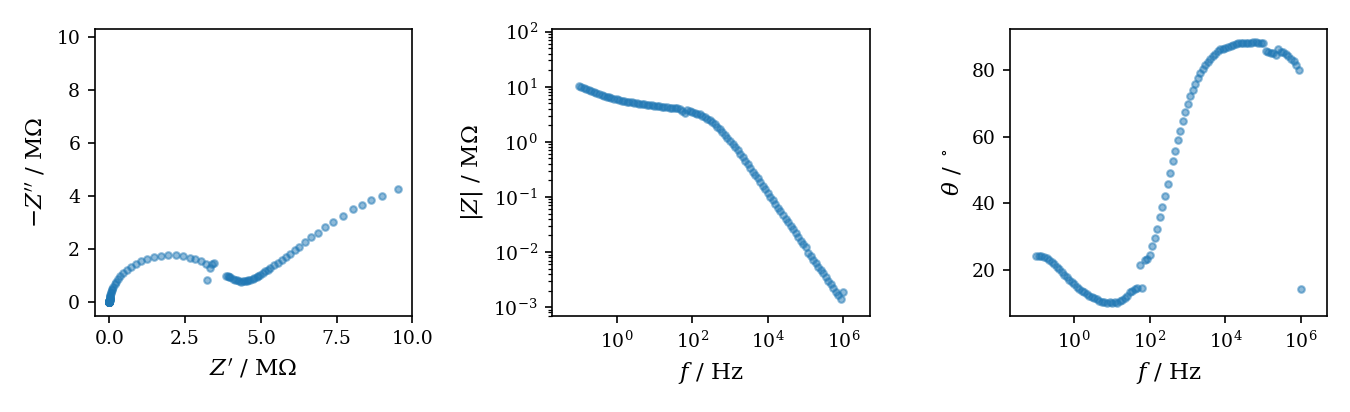

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [5]:
# load experimental data
df = fl.read_eis(os.path.join(datadir,'experimental','PDAC_COM3_02109_Contact10_2065C_500C.txt'))

# Extract frequency and impedance arrays
freq, Z = fl.get_fZ(df)

# Plot data
axes = bp.plot_eis(df)

The Nyquist and Bode plots reveal several contaminated data points near $f\approx 60 \mathrm{Hz}$.

# 2. Fitting with the standard error model

First, let's fit the data using the default arguments. By default, `fit` uses a standard error model which does not consider outliers. However, after fitting, it will perform a check to determine whether potential outliers are present.

Normal fit time: 15.62 s


c:\users\jdh10\onedrive - colorado school of mines\python\projects\bayes_drt\bayes_drt\inversion.py:1289: UserWarning: Possible outliers were identified at indices [[63]
 [64]], f=[[62.91946]
 [53.87931]] Hz. Check the residuals and consider re-running with outliers=True
  outlier_idx, frequencies[outlier_idx]))


<IPython.core.display.Javascript object>


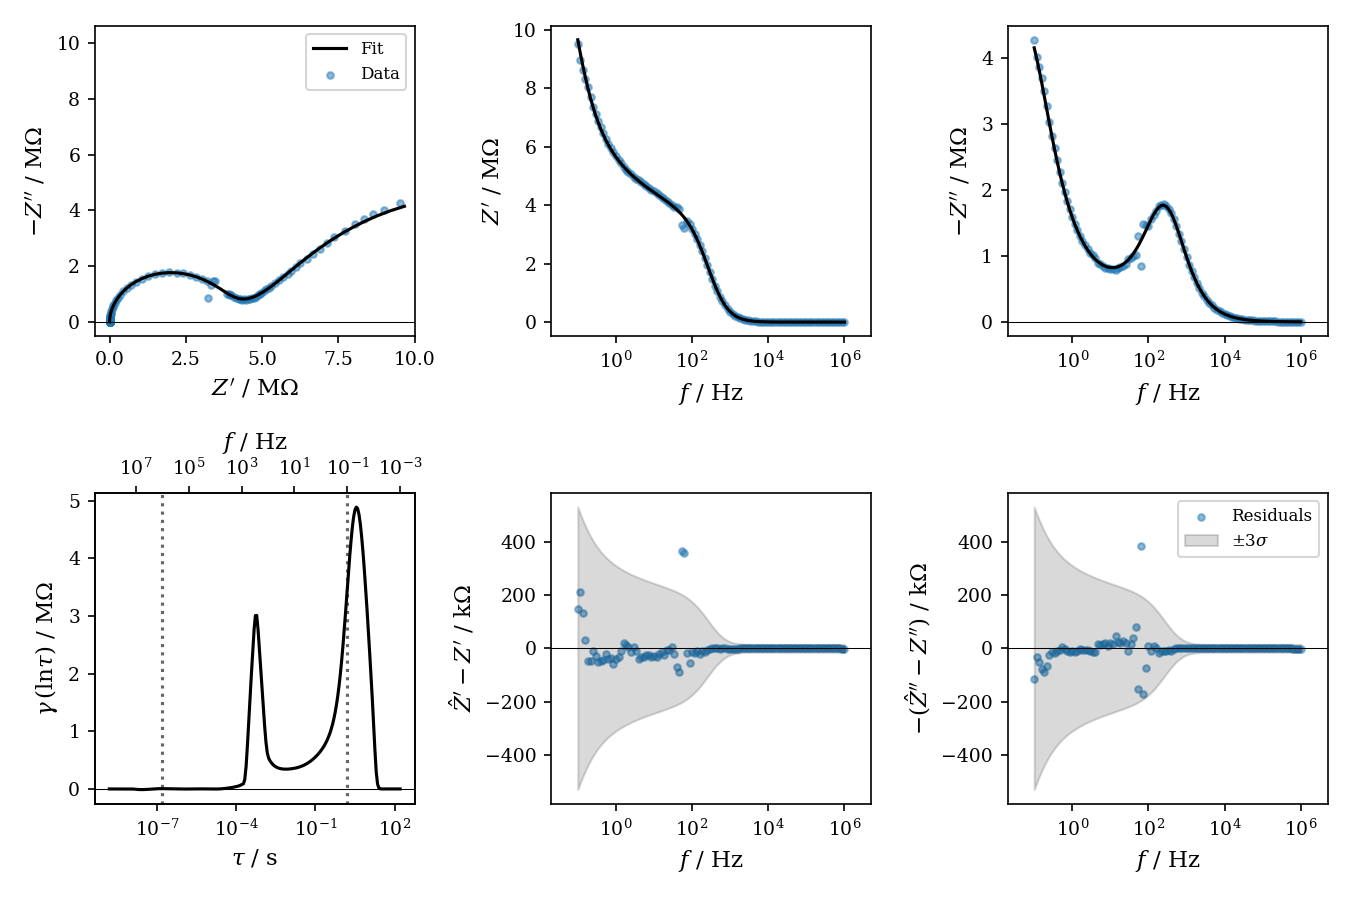

In [7]:
inv = Inverter()

# Fit with normal error model
start = time.time()
inv.fit(freq, Z)
print('Normal fit time: {:.2f} s'.format(time.time() - start))

# Plot results
axes = inv.plot_full_results()

We can see that the fit of the low-frequency data is slightly off. In the residual plots, we can see that the estimated error structure far overestimates the error magnitude at low frequencies. This is due to the corrupted data points near 60 Hz, which inflate the error estimate.

The `Inverter` instance provides us with a warning that likely outliers were detected at 54 and 63 Hz. 

# 3. Fitting with the outlier-robust error model (manual)
Since we can visually identify the outliers in this spectrum (and/or with the warning from `fit`), we can manually specify that the outlier-robust error model should be used by passing the argument `outliers=True` to `fit`, as shown below.

Normal fit time: 20.70 s


<IPython.core.display.Javascript object>


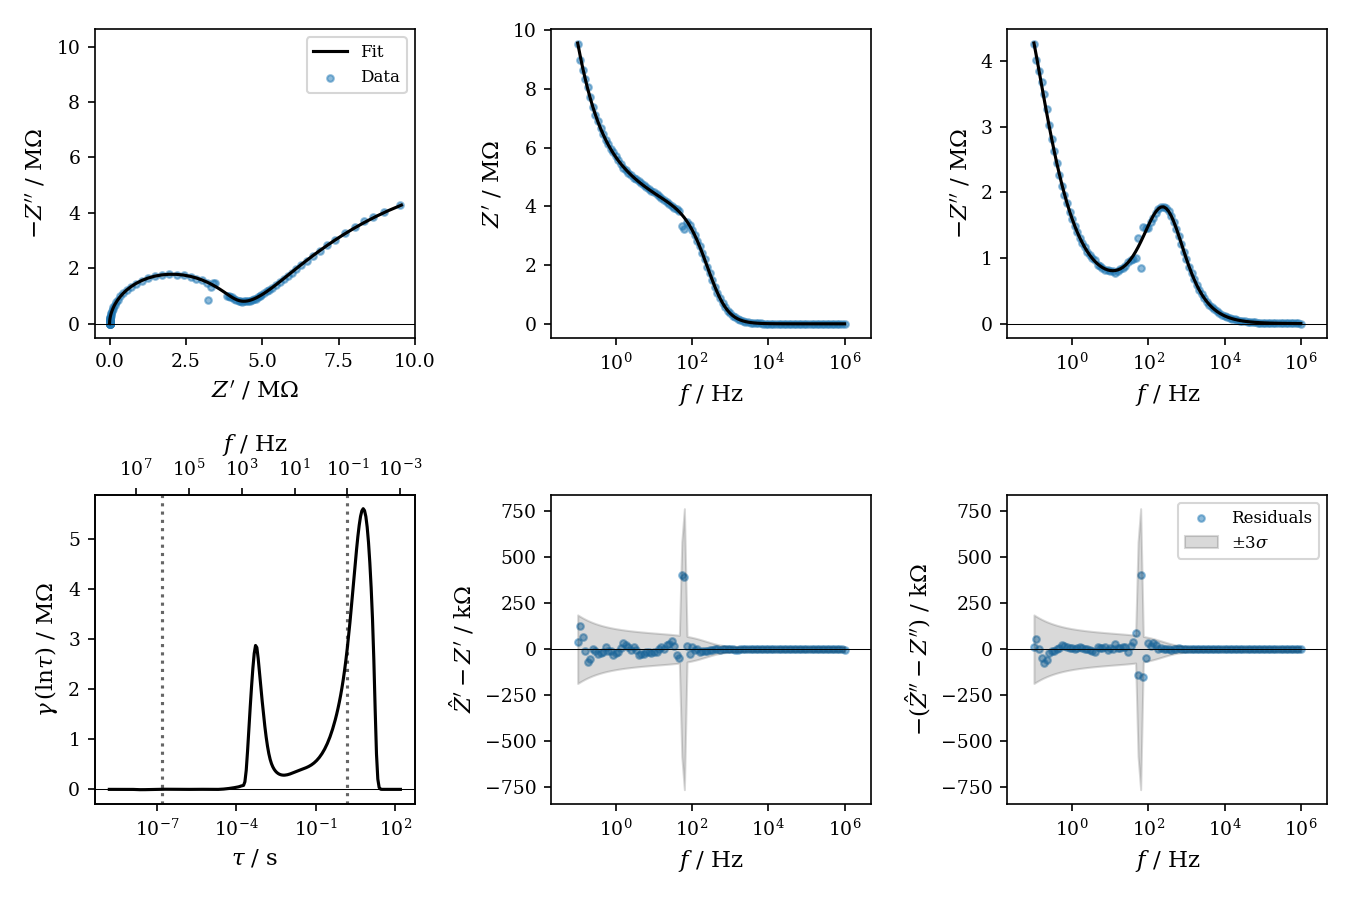

In [8]:
# Fit with outlier-robust error model
start = time.time()
inv.fit(freq, Z, outliers=True)
print('Normal fit time: {:.2f} s'.format(time.time() - start))

# Plot results
axes = inv.plot_full_results()

In the residual plots, we can see that the estimated error structure clearly captures the outliers: the error magnitude is much smaller over most of the frequency range, but contains a spike near 60 Hz which addresses the outliers. As a result, the fit of the low-frequency data is much better than with the standard error model.

# 4. Fitting with automatic outlier management
We can also run `fit` with automatic outlier management, such that it will check for outliers and determine whether or not the outlier-robust error model should be used. This can be enabled by passing `outliers='auto'`, as shown below.

c:\users\jdh10\onedrive - colorado school of mines\python\projects\bayes_drt\bayes_drt\inversion.py:1185: UserWarning: Identified likely outliers at indices [[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [14]
 [63]
 [64]], f=[[1.000020e+06]
 [8.577539e+05]
 [7.356445e+05]
 [6.309961e+05]
 [5.412305e+05]
 [4.642383e+05]
 [3.981445e+05]
 [3.415430e+05]
 [1.166602e+05]
 [6.291946e+01]
 [5.387931e+01]] Hz. An outlier-robust error model will be used. To disable this behavior, pass outliers=False.
  outlier_idx, frequencies[outlier_idx]))


Normal fit time: 20.78 s


<IPython.core.display.Javascript object>


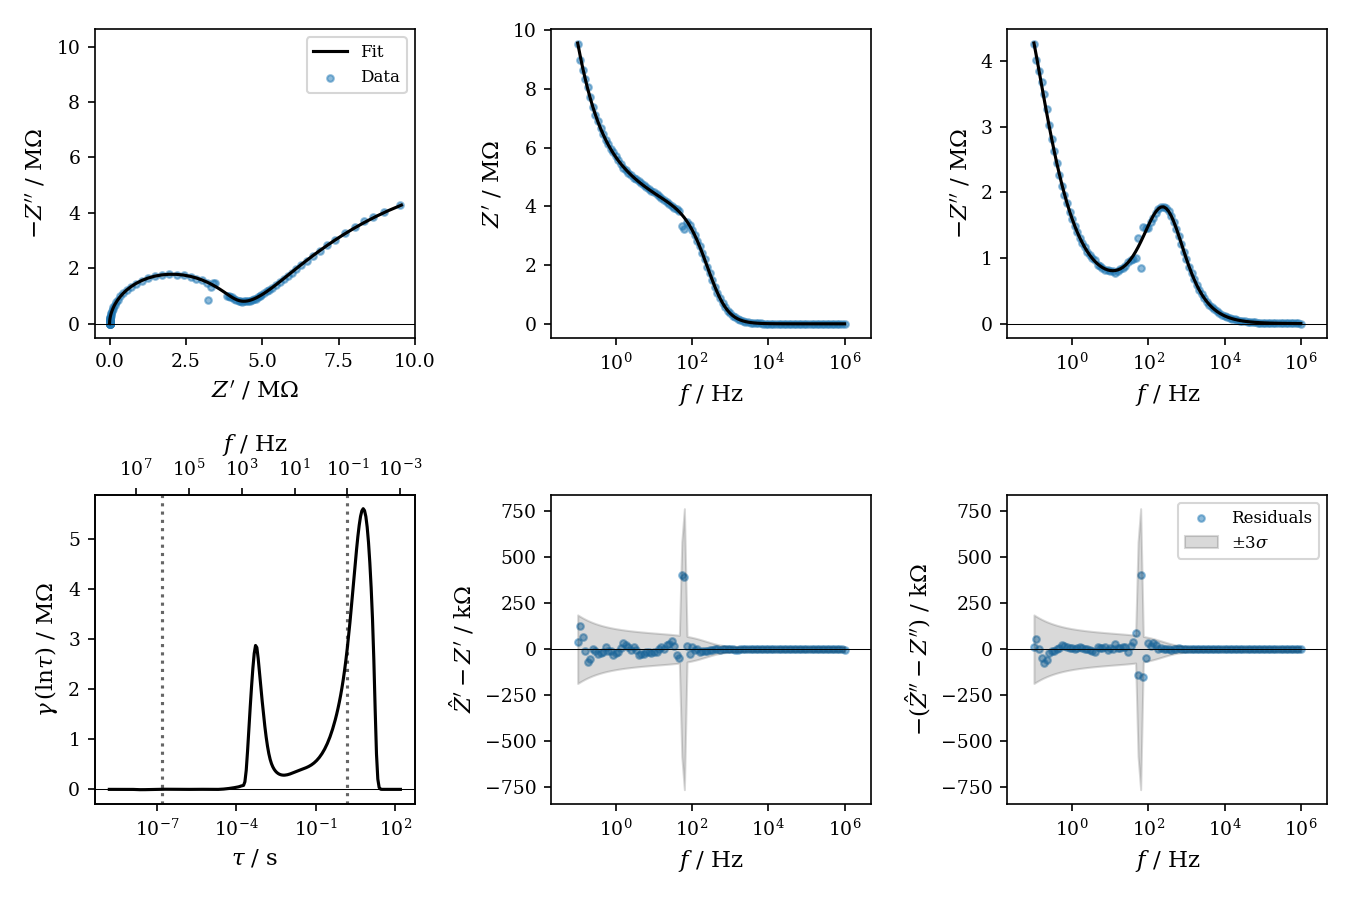

In [9]:
# Fit with automatic outlier management
start = time.time()
inv.fit(freq, Z, outliers='auto')
print('Normal fit time: {:.2f} s'.format(time.time() - start))

# Plot results
axes = inv.plot_full_results()

The `Inverter` instance notifies us that likely outliers were identified and that the outlier-robust error model will be employed, which yields the same result as when we manually specify that outliers are present.